# Create data input for Snuba from preprocessed data
& generate probabilistic labels

Previous:  
[```~/snuba/data/create_threshold.ipynb```](http://localhost:8888/notebooks/snuba/data/create_threshold.ipynb).  

[```~/snuba/Extract Thresholds.ipynb```](http://localhost:8888/notebooks/snuba/Extract%20Thresholds.ipynb).  



#### INPUT: 
~~/snuba/data/[dataset_xx]/snuba-dataset_xx.csv~~  
`root/snuba/data/labeled_data/modified_dataset_xx.csv`

#### OUTPUT: 
(for each input dataset XX, will create a directory `/snuba/input_snuba/dataset_XX/`)  

`  
train_primitive_matrix.npy (primitive = features)
val_primitive_matrix.npy
test_primitive_matrix.npy
train_original.csv
val_original.csv
test_original.csv
train_probs.npy (prob labels for training set)
val_ground.npy
test_ground.npy
`

In [1]:
global_features = ['noise', 'outage', 'congestion', 'changepoint'] 
# list of labeled features contained in snuba/input_snuba/labeled_data/ CSVs

In [2]:
# Load synthetic data
import pandas as pd
import numpy as np
# synth = pd.read_csv("../MTL/data/synth_gap500.csv", index_col=0)
# synth = pd.read_csv('../MTL/data/synth_latest.csv', index_col=0)
# del synth['WMA']
# del synth['dist']
# synth

In [3]:
import sys, os, glob
import pandas as pd
import numpy as np
import random

from sklearn import *

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sys.path.append('../')
from utils import get_full_path

db_dir = get_full_path('data_28')
snuba_input_dir = get_full_path('snuba', 'data')
snuba_labeled_input_dir = get_full_path('snuba', 'data', 'labeled_data')
snuba_split_set_dir = get_full_path('snuba', 'input_snuba')
FIGURE_DIR = get_full_path('snuba', 'input_snuba', 'Figures')

from snuba.data.data_loader import DataLoader
from snuba.program_synthesis.heuristic_generator import HeuristicGenerator
from snuba.program_synthesis.synthesizer import Synthesizer
from snuba.program_synthesis.verifier import Verifier

np.random.seed(42)
os.chdir(db_dir)

datasets = glob.glob('*.csv')
datasets_sorted = sorted(datasets)

In [4]:
def create_sets(client, selected_feature):
    if client.endswith('.csv'):
        client_name = str(client[:-4])
    assert selected_feature in global_features
    
#     input_dir = snuba_input_dir + '/' + client_name # read from snuba/data/dataset_xx
#     output_dir = snuba_split_set_dir + '/' + client_name
    
    input_dir = f'{snuba_labeled_input_dir}/' # read from labeled data; snuba/data/labeled_data/____.csv
    
    # store features in snuba/input_snuba/dataset_xx/{selected_feature}/
    output_dir = snuba_split_set_dir + '/' + client_name + '/' + selected_feature
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    os.chdir(input_dir)
    
    ### get name of labeled CSV; this should be the output files from Extract Thresholds.ipynb
    # dataset = f'snuba-labeled-{client}' # get name of labeled CSV
    dataset = f'modified_snuba_{client}' # 'modified_snuba_dataset_XX.csv'
    
    dl = DataLoader()
#     train_primitive_matrix, val_primitive_matrix, test_primitive_matrix, \
#     train_ground, val_ground, test_ground, \
#     train_original, val_original, test_original = \
#                     dl.load_feature(dataset=dataset, data_path=input_dir, feature=selected_feature)
#                     # this reads from snuba/data/ , which doesn't have the new labels
#                     # dl.load_data(dataset=dataset, data_path=input_dir+'/')
    train_primitive_matrix, val_primitive_matrix, test_primitive_matrix, \
    train_ground, val_ground, test_ground, \
    train_original, val_original, test_original = \
                    dl.select_feature(dataset=dataset, data_path=input_dir, feature=selected_feature)
    
            
    os.chdir(output_dir)
#     print(f"Writing output sets to {output_dir}")
    
    np.save('train_primitive_matrix_' + client_name, train_primitive_matrix)
    np.save('val_primitive_matrix_'+ client_name, val_primitive_matrix)
    np.save('test_primitive_matrix_'+ client_name, test_primitive_matrix)
    np.save('val_ground_' + client_name, val_ground)
    np.save('test_ground_' + client_name, test_ground)
    
    train_original.to_csv(f'train_original_{client_name}.csv', encoding='utf-8')
    val_original.to_csv(f'val_original_{client_name}.csv', encoding='utf-8')
    test_original.to_csv(f'test_original_{client_name}.csv', encoding='utf-8')

In [5]:
def generate_prob_labels(client, selected_feature, save_figures=False, normalize_graph=True, GAMMA=0.1, B=0.5):
    client_name = str(client[:-4])
    assert selected_feature in global_features
    
    input_dir  = f'{snuba_split_set_dir}/{client_name}/{selected_feature}' # snuba/input_snuba/dataset_XX/<feature>
    output_dir = f'{snuba_split_set_dir}/{client_name}/{selected_feature}'
    
#     print(f"Reading numpy caches from {input_dir}")
    
#     input_dir = snuba_split_set_dir+'/'+client_name
#     output_dir = snuba_split_set_dir+'/'+client_name
    
    train_primitive_matrix = np.load(glob.glob('train_primitive_matrix_*')[0])
    val_primitive_matrix = np.load(glob.glob('val_primitive_matrix_*')[0])
    test_primitive_matrix = np.load(glob.glob('test_primitive_matrix_*')[0])
    val_ground = np.load(glob.glob('val_ground_*')[0])
    test_ground = np.load(glob.glob('test_ground_*')[0])

    # Snuba Synthesizer
    hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, val_ground, b=B)
    hg.run_synthesizer(max_cardinality=1, idx=None, keep=3, model='dt')

    syn = Synthesizer(val_primitive_matrix, val_ground, b=B)

    heuristics, feature_inputs = syn.generate_heuristics('dt', 1)
    print ("Total Heuristics Generated: ", np.shape(heuristics)[1])
    
    optimal_betas = syn.find_optimal_beta(heuristics[0], val_primitive_matrix, feature_inputs[0], val_ground)
    
    # Snuba Pruner
    top_idx = hg.prune_heuristics(heuristics, feature_inputs, keep=3)
    print ('Features chosen heuristics are based on: ', top_idx)
    
    # Snuba Verifier
    verifier = Verifier(hg.L_train, hg.L_val, val_ground, has_snorkel=True)

    verifier.train_gen_model()
    verifier.assign_marginals()

    feedback_idx = verifier.find_vague_points(gamma=GAMMA,b=B) # original
    
    print ('Percentage of Low Confidence Points: ', np.shape(feedback_idx)[0] / float(np.shape(val_ground)[0]))

    # Repeat iterative process
    validation_accuracy = []
    
    validation_coverage = []
    training_coverage = []

    training_marginals = []
    idx = None
    
    hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, val_ground, b=B)
    
    plt.figure(figsize=(12,6));
    for i in range(3,26):
        if (i-2)%5 == 0:
            print ("Running iteration: ", str(i-2))

        #Repeat synthesize-prune-verify at each iterations
        if i == 3:
            hg.run_synthesizer(max_cardinality=1, idx=idx, keep=3, model='dt')
        else:
            hg.run_synthesizer(max_cardinality=1, idx=idx, keep=1, model='dt')
        hg.run_verifier()

        #Save evaluation metrics
        va, vc, tc = hg.evaluate()
        validation_accuracy.append(va)

        training_marginals.append(hg.vf.train_marginals)
        validation_coverage.append(vc)
        training_coverage.append(tc)

        # Plot of Training Set Label Distribution:
        if i <= 8:
            plt.subplot(2,3,i-2)
            
            if normalize_graph:
                # Show quantity of labeled points as ratios, rather than raw values.
                data = training_marginals[-1]
                weight = np.ones(len(data)) / len(data)
                plt.hist(data, bins=10, range=(0.0,1.0), weights=weight); 
            else:
                plt.hist(training_marginals[-1], bins=10, range=(0.0,1.0));  # show quantity of points
            
            plt.title(f'Training Set {client_name[-2:]} - Iteration {str(i-2)}');
            plt.xlim([0.0,1.0])
#             plt.ylim([0,825]) # remove limit on height for graphs
            plt.grid(axis='y', color="#444444") # add y-axis grid lines
    
            if save_figures: # save figures to snuba/input_snuba/Figures/
                plt.savefig(f"{FIGURE_DIR}/{selected_feature}_{client_name}", bbox_inches='tight')

        #Find low confidence datapoints in the labeled set
        hg.find_feedback()
        idx = hg.feedback_idx

        #Stop the iterative process when no low confidence labels
        if idx == []:
            break
    
    os.chdir(output_dir)
    print(f"Writing probs labels to {output_dir}")
    
#     print(f"probs_labels_client = ", training_marginals[-1])
    
    np.save('probs_labels_'+client[:-4]+'.npy', training_marginals[-1])

Feature Extraction: 100%|██████████| 120/120 [00:01<00:00, 69.38it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 5]
Inferred cardinality: 2
Percentage of Low Confidence Points:  1.0
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_01/changepoint


Feature Extraction: 100%|██████████| 116/116 [00:01<00:00, 81.61it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.8602941176470589
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_02/changepoint


Feature Extraction: 100%|██████████| 116/116 [00:01<00:00, 89.91it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [5 4 3]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.0
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_03/changepoint


Feature Extraction: 100%|██████████| 120/120 [00:01<00:00, 83.42it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7617866004962779
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_04/changepoint


Feature Extraction: 100%|██████████| 117/117 [00:01<00:00, 75.66it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.8758169934640523
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_05/changepoint


Feature Extraction: 100%|██████████| 115/115 [00:01<00:00, 98.90it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7987220447284346
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_06/changepoint


Feature Extraction: 100%|██████████| 118/118 [00:01<00:00, 61.03it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 5]
Inferred cardinality: 2
Percentage of Low Confidence Points:  1.0
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_07/changepoint


Feature Extraction: 100%|██████████| 119/119 [00:01<00:00, 77.94it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 5]
Inferred cardinality: 2
Percentage of Low Confidence Points:  1.0
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_08/changepoint


Feature Extraction: 100%|██████████| 120/120 [00:01<00:00, 90.50it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 5]
Inferred cardinality: 2
Percentage of Low Confidence Points:  1.0
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_09/changepoint


Feature Extraction: 100%|██████████| 120/120 [00:01<00:00, 93.37it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7528089887640449
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_10/changepoint


Feature Extraction: 100%|██████████| 115/115 [00:01<00:00, 100.26it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7652733118971061
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_11/changepoint


Feature Extraction: 100%|██████████| 118/118 [00:01<00:00, 99.56it/s] 


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [5 4 3]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.0
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_12/changepoint


Feature Extraction: 100%|██████████| 117/117 [00:01<00:00, 93.33it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7732558139534884
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_13/changepoint


Feature Extraction: 100%|██████████| 120/120 [00:01<00:00, 72.81it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 5]
Inferred cardinality: 2
Percentage of Low Confidence Points:  1.0
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_14/changepoint


Feature Extraction: 100%|██████████| 117/117 [00:01<00:00, 78.29it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7414187643020596
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_15/changepoint


Feature Extraction: 100%|██████████| 115/115 [00:01<00:00, 85.54it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7931937172774869
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_16/changepoint


Feature Extraction: 100%|██████████| 119/119 [00:01<00:00, 78.60it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7937219730941704
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_17/changepoint


Feature Extraction: 100%|██████████| 119/119 [00:01<00:00, 63.35it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7546848381601363
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_18/changepoint


Feature Extraction: 100%|██████████| 119/119 [00:01<00:00, 69.46it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.793036750483559
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_19/changepoint


Feature Extraction: 100%|██████████| 117/117 [00:01<00:00, 89.24it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.852054794520548
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_20/changepoint


Feature Extraction: 100%|██████████| 120/120 [00:01<00:00, 77.92it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.8303571428571429
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_21/changepoint


Feature Extraction: 100%|██████████| 116/116 [00:01<00:00, 81.58it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7750611246943765
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_22/changepoint


Feature Extraction: 100%|██████████| 118/118 [00:01<00:00, 62.47it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.7701543739279588
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_23/changepoint


Feature Extraction: 100%|██████████| 120/120 [00:01<00:00, 66.68it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 5]
Inferred cardinality: 2
Percentage of Low Confidence Points:  1.0
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_24/changepoint


Feature Extraction: 100%|██████████| 118/118 [00:01<00:00, 60.97it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 5]
Inferred cardinality: 2
Percentage of Low Confidence Points:  1.0
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_25/changepoint


Feature Extraction: 100%|██████████| 117/117 [00:01<00:00, 99.74it/s] 


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.734375
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_26/changepoint


Feature Extraction: 100%|██████████| 120/120 [00:01<00:00, 70.50it/s]


Total Heuristics Generated:  8
Features chosen heuristics are based on:  [7 6 2]
Inferred cardinality: 2
Percentage of Low Confidence Points:  0.8151260504201681
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  5
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  10
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  15
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Running iteration:  20
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Writing probs labels to /users/jknof/multitaskws/snuba/input_snuba/dataset_27/changepoint


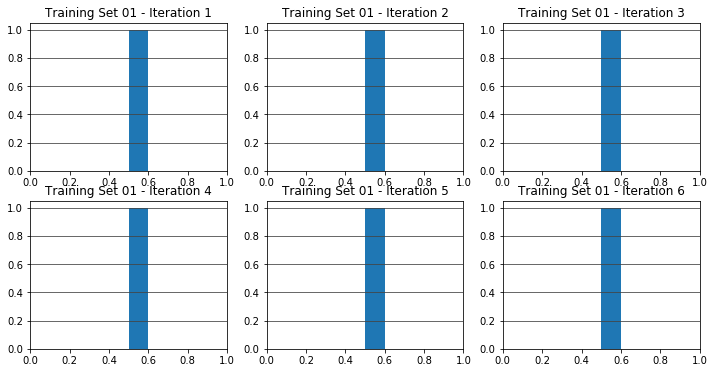

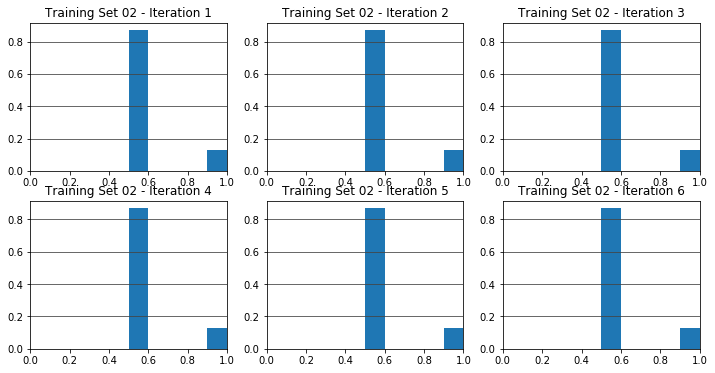

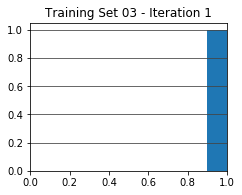

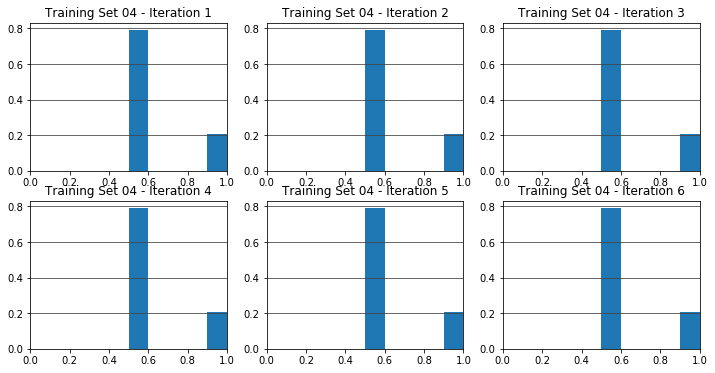

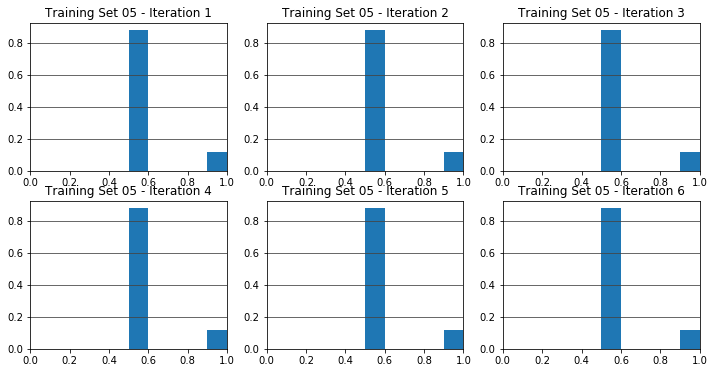

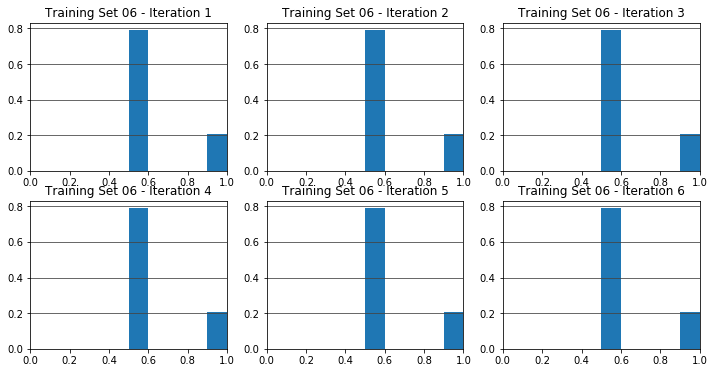

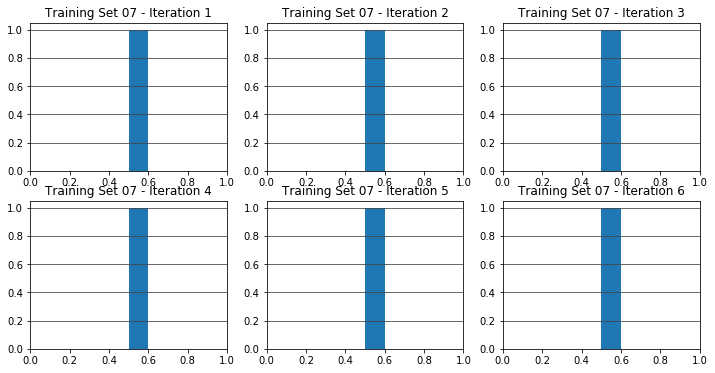

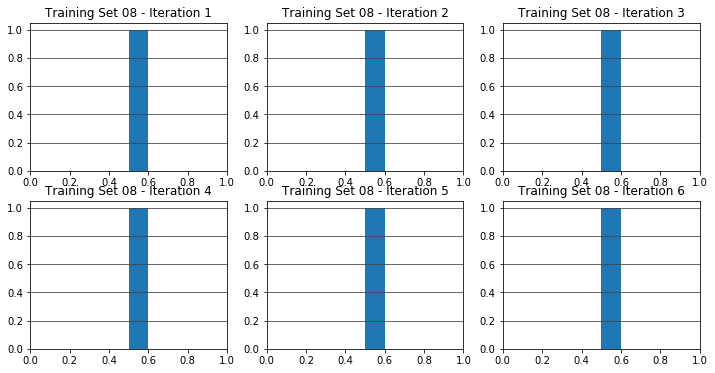

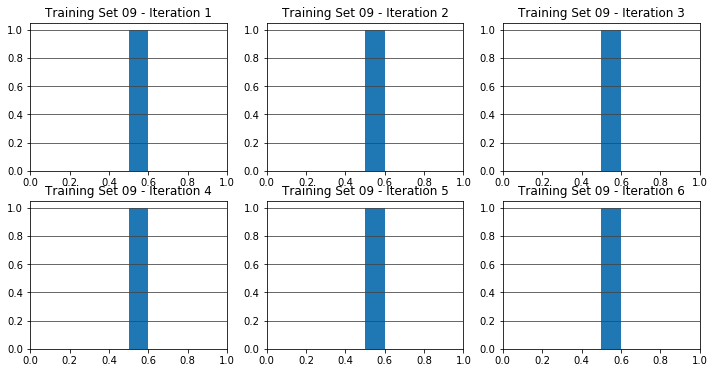

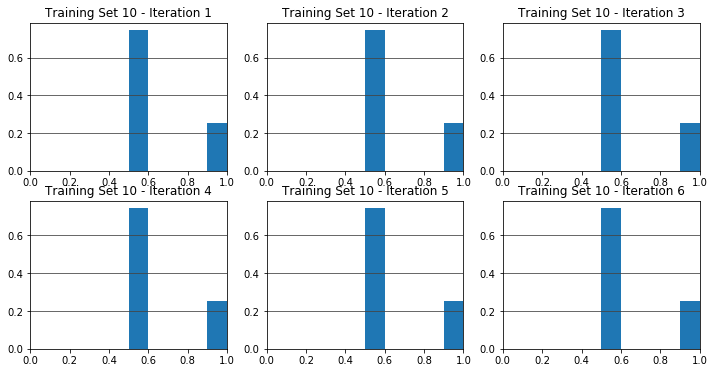

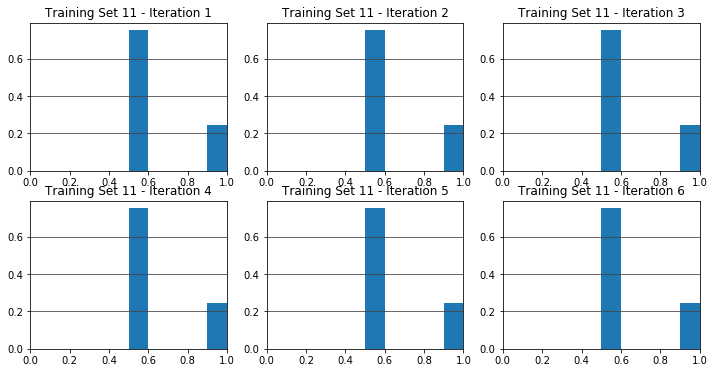

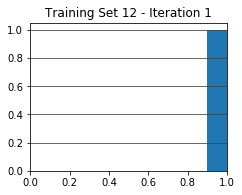

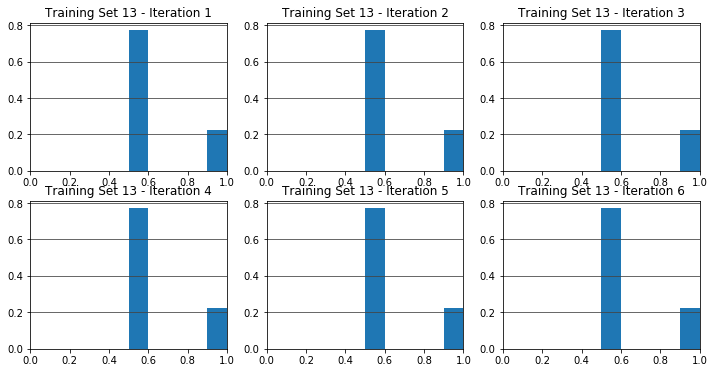

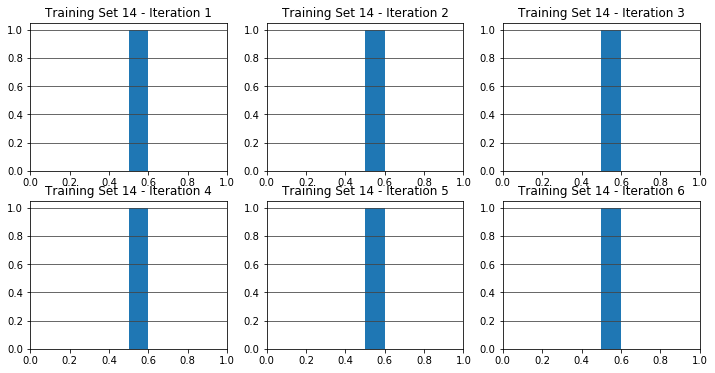

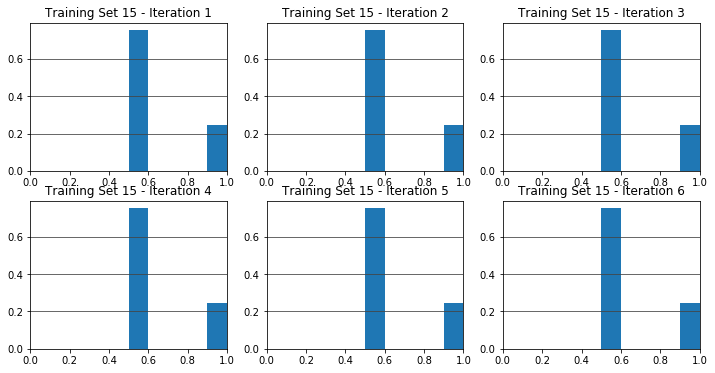

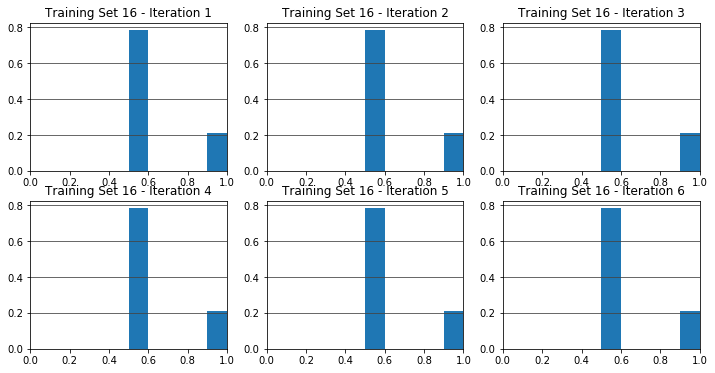

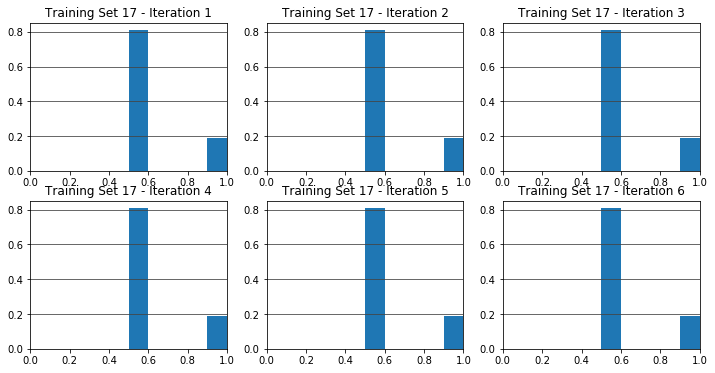

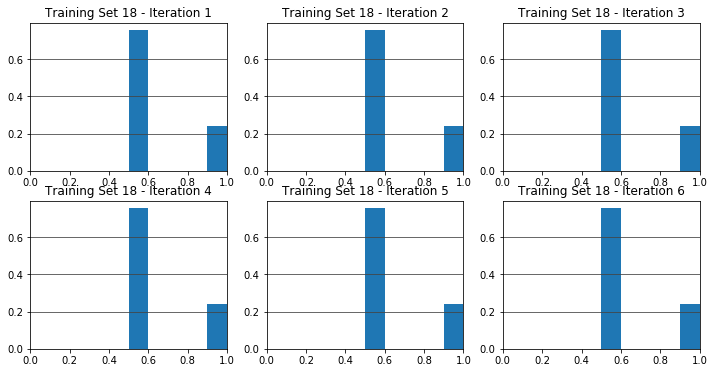

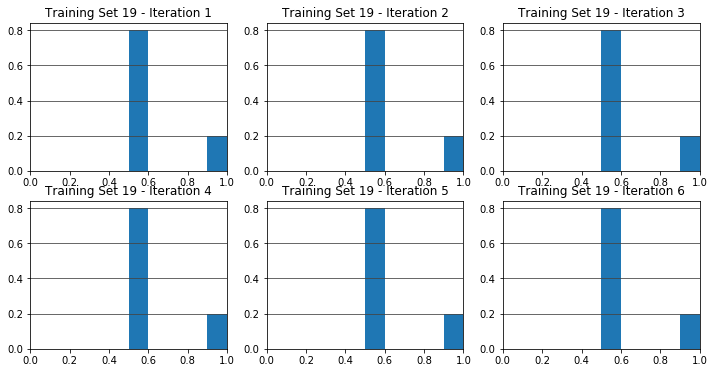

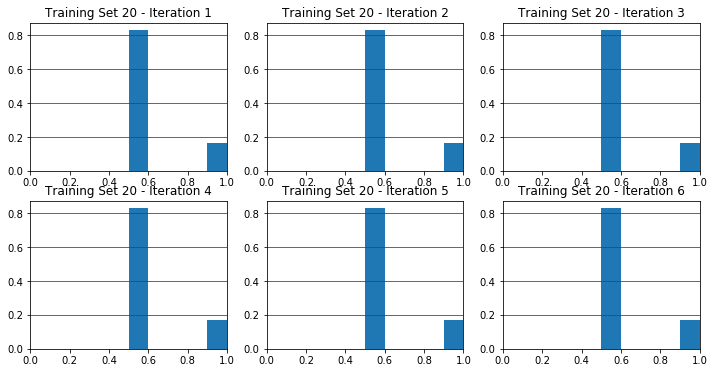

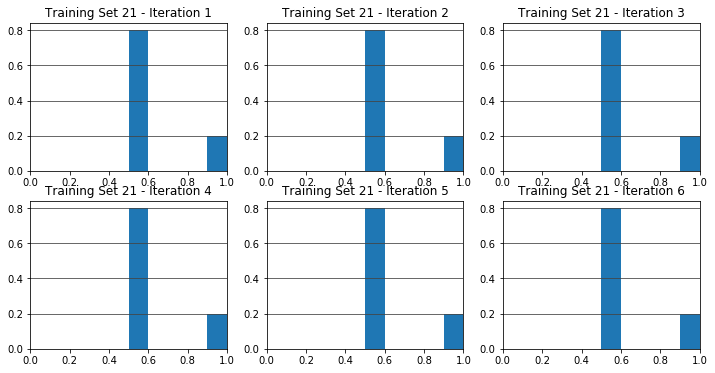

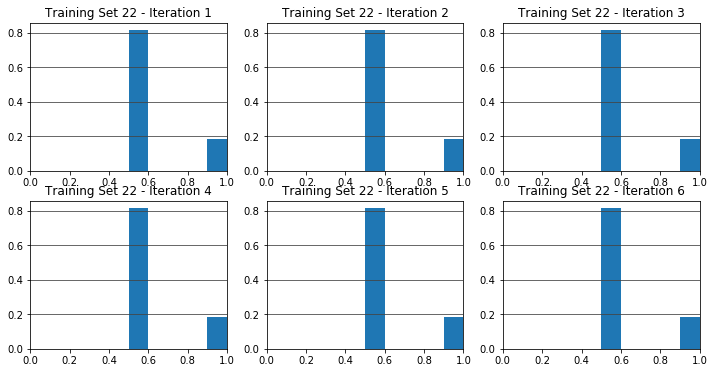

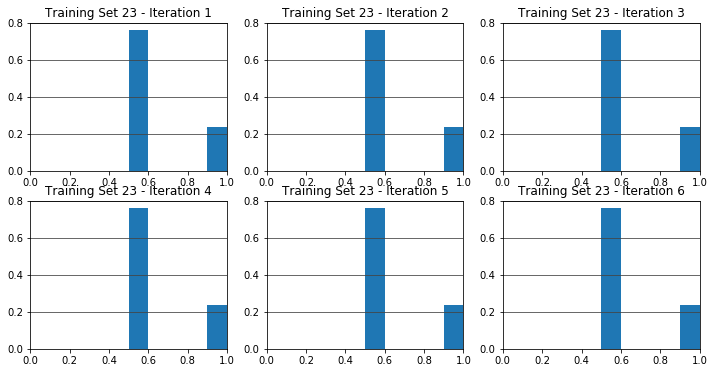

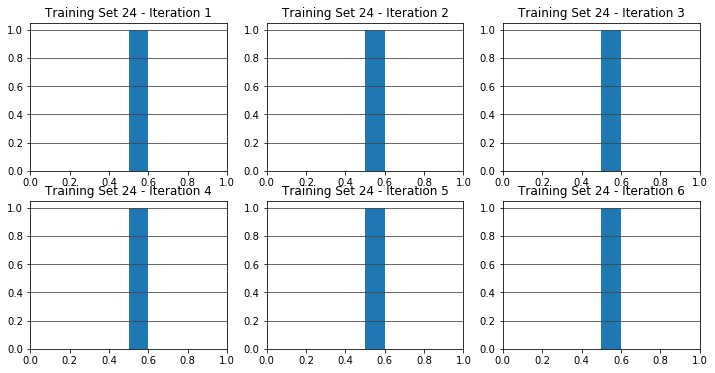

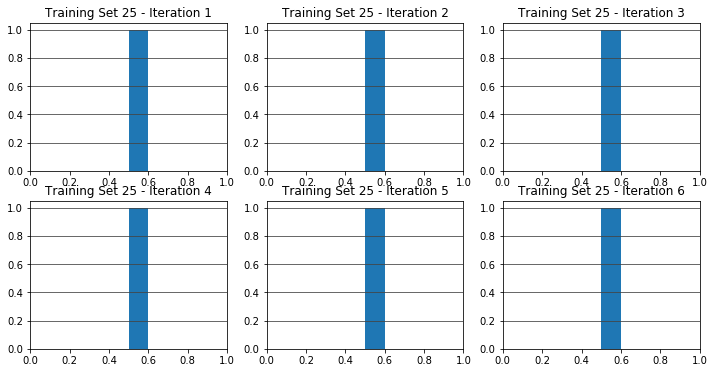

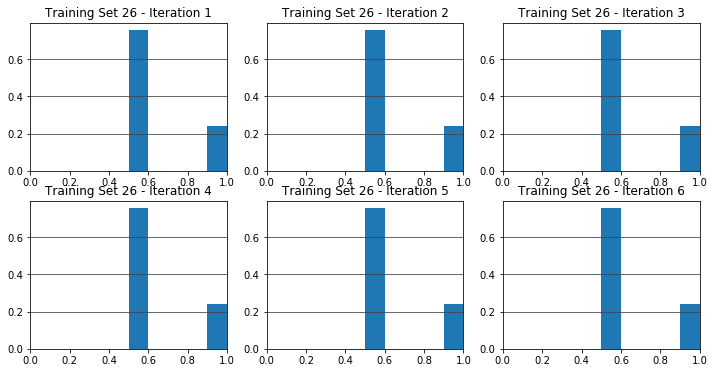

In [9]:
import time, statistics
precision = 5 # round time measurements to this many decimal places

# feature = 'congestion' # current feature to gen. probs. labels for. valid options are 'noise', 'outage', and 'congestion'.
# feature = 'noise'
# feature = 'outage'
feature = 'changepoint'

create_sets_times = []
generate_labels_times = []
clients = datasets_sorted # in range 00..27

# for client in clients[1:28]:
for client in clients:
    start = time.clock()
    create_sets(client, feature)
    end = time.clock()
    create_sets_times.append(round(end - start, 5))
    
    start = time.clock()
#     generate_prob_labels(client, feature, normalize_graph=True, save_figures=False, B=0.05) # 0.05 gives ~60% accuracy
    generate_prob_labels(client, feature, normalize_graph=True, save_figures=False) # use default B value of 0.5
    end = time.clock()
    generate_labels_times.append(round(end - start, precision))

In [ ]:
# Print results. Output is pre-formatted for placement in a markdown cell.
print("______________________________  ")
print(f"#### Feature: `{feature}`  ")
print(f"Average label generation time:   `{round(statistics.mean(generate_labels_times), precision)}` seconds  ")
print(f"Average set creation time:       `{round(statistics.mean(create_sets_times), precision)}` seconds  ")
print(f"Total time:                      `{round(sum(create_sets_times) + sum(generate_labels_times), precision)}` seconds  ")
print(f"\nLabels:  \n`{generate_labels_times}`  \nSets:  \n`{create_sets_times}`  ")

After probabilistic labels are created, evaluate label quality by training the LSTM. 

Next: [```~/snuba/evaluate_label_quality_lstm.ipynb```](http://localhost:8888/notebooks/snuba/evaluate_label_quality_lstm.ipynb)

## Probabilistic Label Time Measurements

#### Feature: `outage`  
Average label generation time:  `8.33112` seconds  
Average set creation time:  `3.02162` seconds  
Total time:  `317.87687` seconds  

Labels:  
`[8.18956, 9.4667, 8.03292, 8.26553, 7.61892, 8.0015, 6.26007, 10.48234, 7.75351, 7.24537, 6.7646, 6.11679, 7.26958, 6.70461, 9.28228, 7.76104, 7.53128, 8.76437, 11.63429, 9.37959, 7.13831, 8.52129, 7.97796, 10.8647, 10.11326, 10.83101, 6.40882, 8.89128]`  
Sets:  
`[2.67456, 3.09566, 2.76075, 2.93523, 2.83805, 2.92742, 2.60524, 3.44293, 2.84906, 2.75564, 3.53077, 2.60372, 2.90751, 2.8643, 3.31597, 2.69046, 2.81498, 2.95557, 3.74237, 3.20966, 2.78822, 3.0718, 3.15064, 3.37701, 3.20348, 4.10227, 2.51449, 2.87763]`  
______________________________  
#### Feature: `noise`  
Average label generation time:  `8.33464` seconds  
Average set creation time:  `2.31467` seconds  
Total time:  `298.18051` seconds  

Labels:  
`[8.37091, 9.53169, 7.96299, 8.16526, 7.77153, 8.03011, 6.31486, 10.55752, 7.92521, 7.29241, 6.89855, 6.3221, 7.35505, 6.81156, 9.26502, 7.84748, 7.46311, 8.72527, 11.49376, 9.25419, 7.11456, 8.33409, 7.97167, 10.8292, 9.94801, 10.71212, 6.25557, 8.84598]`  
Sets:  
`[2.12819, 2.38605, 2.24814, 2.23297, 2.06954, 2.30431, 1.82976, 2.62475, 2.12476, 2.19462, 1.96606, 1.84082, 2.02825, 1.97837, 2.67652, 2.166, 2.09265, 2.30161, 2.88663, 2.74676, 2.05582, 2.35578, 2.32585, 2.82815, 2.77224, 3.13524, 2.04183, 2.46906]`  

______________________________  
#### Feature: `congestion`  
Average label generation time:   `4.00139` seconds  
Average set creation time:       `1.53753` seconds  
Total time:                      `155.0898` seconds  

Labels:  
`[3.94867, 4.66687, 3.62983, 3.34692, 3.60912, 4.11949, 2.8418, 5.34807, 4.05839, 3.44188, 3.29029, 2.88446, 3.09493, 3.23576, 4.49993, 4.04998, 3.50691, 4.11771, 5.33758, 4.68278, 3.35698, 4.08218, 3.76967, 5.24457, 5.00598, 5.5779, 2.9355, 4.35467]`  
Sets:  
`[1.41812, 1.64296, 1.50172, 1.29212, 1.3993, 1.46972, 1.19072, 1.98999, 1.44291, 1.35072, 1.34877, 1.2159, 1.40252, 1.35608, 1.86764, 1.53606, 1.37355, 1.52816, 1.84695, 1.67527, 1.38635, 1.53331, 1.70345, 1.81714, 1.80552, 1.9236, 1.37053, 1.6619]` 
______________________________  